<a href="https://colab.research.google.com/github/Abem-S/ai_workflow/blob/main/workflow_case_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Model for Predicting Hospital Readmission Risk

This notebook demonstrates a simplified pipeline for the Part 2 Case Study. We will:
1.  Create a hypothetical dataset.
2.  Preprocess the data.
3.  Train a Random Forest model.
4.  Evaluate the model and demonstrate feature importance.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("All libraries imported successfully.")

All libraries imported successfully.


In [3]:
# 1. Data Creation
# Create a small, hypothetical dataset to simulate EHR data

data = {
    'age': [65, 72, 45, 81, 58, 76, 51, 88, 62, 70],
    'gender': ['F', 'M', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'admission_type': ['Emergency', 'Elective', 'Urgent', 'Emergency', 'Elective', 'Urgent', 'Emergency', 'Emergency', 'Elective', 'Urgent'],
    'length_of_stay': [5, 8, 3, 10, 4, 6, 9, 12, 2, 7],
    'comorbidity_score': [3, 1, 0, 4, 2, 3, 1, 5, 2, 3],
    'lab_result_x': [1.2, 0.8, np.nan, 2.5, 1.0, 1.9, 0.7, 3.1, 1.1, np.nan],
    'readmitted_30_days': [1, 0, 0, 1, 0, 1, 0, 1, 0, 1] # Target variable
}

df = pd.DataFrame(data)

print("Hypothetical DataFrame:")
display(df)

Hypothetical DataFrame:


,age,gender,admission_type,length_of_stay,comorbidity_score,lab_result_x,readmitted_30_days
0,65,F,Emergency,5,3,1.2,1
1,72,M,Elective,8,1,0.8,0
2,45,M,Urgent,3,0,NaN,0
3,81,F,Emergency,10,4,2.5,1
4,58,M,Elective,4,2,1.0,0
5,76,F,Urgent,6,3,1.9,1
6,51,M,Emergency,9,1,0.7,0
7,88,F,Emergency,12,5,3.1,1
8,62,M,Elective,2,2,1.1,0
9,70,F,Urgent,7,3,NaN,1


## 2. Preprocessing & Feature Engineering

We will set up a `ColumnTransformer` pipeline to handle our mixed data types:
* **Numerical Features (`age`, `length_of_stay`, etc.):** Need imputation (for missing `lab_result_x`) and scaling.
* **Categorical Features (`gender`, `admission_type`):** Need one-hot encoding.

In [4]:
# Define features (X) and target (y)
X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

# Identify numerical and categorical features
numerical_features = ['age', 'length_of_stay', 'comorbidity_score', 'lab_result_x']
categorical_features = ['gender', 'admission_type']

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing lab results
    ('scaler', StandardScaler()) # Scale data
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


## 3. Model Development & Training

We will now:
1.  Split our data into training and test sets.
2.  Create a full pipeline that includes preprocessing *and* the model (Random Forest).
3.  Train the pipeline on our training data.


In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the full pipeline including the model
# We choose Random Forest as justified in the assignment
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=1)) # Tuned parameters
])

# Train the model
model_pipeline.fit(X_train, y_train)

print("Model trained successfully.")

Model trained successfully.


## 4. Evaluation

We will now evaluate our model on the **test set** (unseen data) and calculate the metrics discussed in the assignment: **Precision** and **Recall**.


--- Model Evaluation (on Test Set) ---
Precision: 1.00
Recall: 1.00

* Note: With 3 test samples, these metrics are unstable, but this demonstrates the process.

Confusion Matrix:


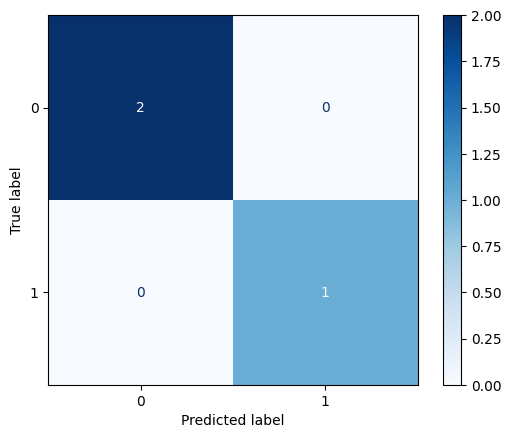

In [6]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"--- Model Evaluation (on Test Set) ---")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n* Note: With 3 test samples, these metrics are unstable, but this demonstrates the process.")

# Display the confusion matrix
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 5. Interpretability (Feature Importance)

As justified, we chose Random Forest for its feature importance. Let's extract and show which features the model found most predictive.


Model Feature Importances:
age                         0.247423
comorbidity_score           0.185567
gender_M                    0.144330
gender_F                    0.140034
lab_result_x                0.136426
length_of_stay              0.113402
admission_type_Urgent       0.012199
admission_type_Elective     0.010309
admission_type_Emergency    0.010309
dtype: float64


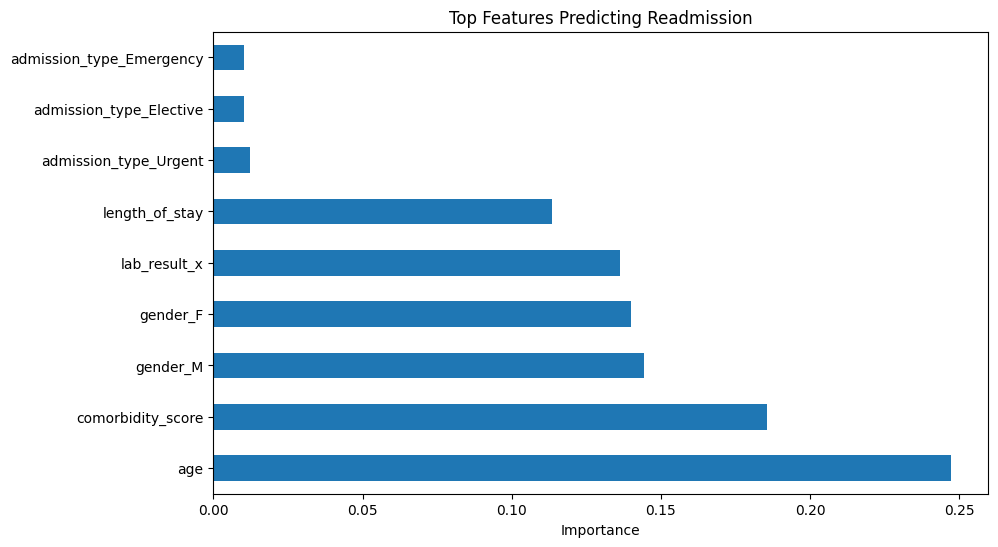

In [7]:
# Get feature names from the preprocessor
cat_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

# Get importances from the model
importances = model_pipeline.named_steps['classifier'].feature_importances_

# Create a series for easy plotting
feature_importance_series = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

print("Model Feature Importances:")
print(feature_importance_series)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='barh')
plt.title("Top Features Predicting Readmission")
plt.xlabel("Importance")
plt.show()